In [1]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP
from Full_model import Integrated_Model

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

name: X_test
shape: (640, 50, 1830)
-----------------------
name: X_train
shape: (640, 50, 1804)
-----------------------
name: clip_sizes_test
shape: (2, 70)
-----------------------
name: clip_sizes_train
shape: (2, 70)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 1830)
-----------------------
name: sel_win_nums_train
shape: (1, 1804)
-----------------------
name: soz_ch_ids
shape: (22, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 1830)
-----------------------
name: y_train
shape: (1, 1804)
-----------------------
print sample EGG signal from one node:


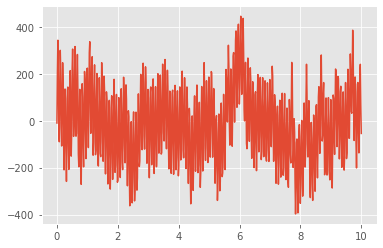

In [32]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_264.mat' #264 253 620 273
variables = load_patient_data(filepath, verbose = True)

In [58]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


In [59]:
#reduce redundant nodes
#from DataManager import get_label_variance as glv
#print(glv(dm.X_train, dm.Y_train))
#print(np.argsort(glv(dm.X_train, dm.Y_train)))
print(dm)
dm.apply_dvariance_filter(28)
dm.mean_pooling_1d(size = 24, stride = 20, padding = 0)
print(dm)

X_train: shape of(1804, 50, 640)
X_test: shape of(1830, 50, 640)
Y_train: shape of(1804, 1)
Y_test: shape of(1830, 1)
A_train: shape of(50, 50)
A_test: shape of(50, 50)
P_avg_train: shape of(50, 50)
P_avg_test: shape of(50, 50)
--------data successfully filtered (dvariance)--------
X_train: shape of(1804, 28, 31)
X_test: shape of(1830, 28, 31)
Y_train: shape of(1804, 1)
Y_test: shape of(1830, 1)
A_train: shape of(28, 28)
A_test: shape of(28, 28)
P_avg_train: shape of(28, 28)
P_avg_test: shape of(28, 28)


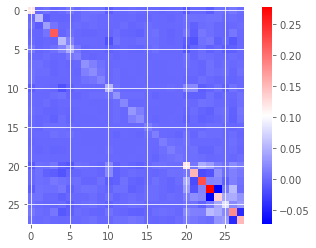

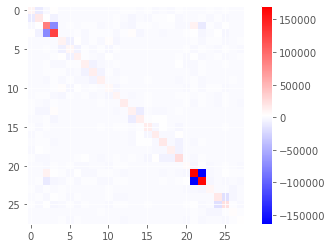

In [60]:
show_heat_map(dm.P_avg_train)
show_heat_map(dm.conv_avg_train)

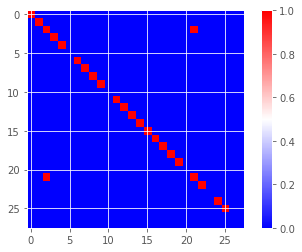

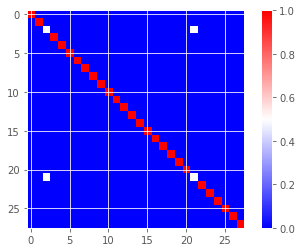

In [61]:
# adjacency generated by convariance
A2 = (dm.conv_avg_train > 10000)# + (dm.conv_avg_train < -8000) 
show_heat_map(A2)
show_heat_map(create_DAD(A2))

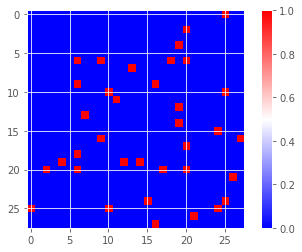

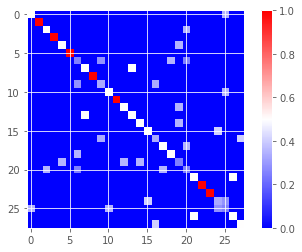

In [62]:
#randomly generated A
b = np.random.randint(-2000,2000,size=dm.conv_avg_train.shape)
A3 = (b + b.T)/2 > 1500
show_heat_map(A3)
show_heat_map(create_DAD(A3))

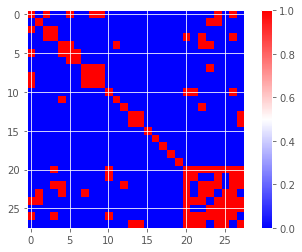

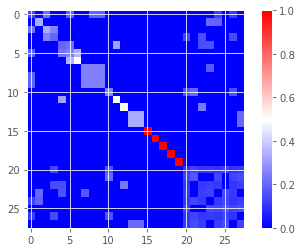

In [75]:
n = 5*10**-3
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
#print(create_DAD(dm.A_train))
Araw =  dm.A_train

In [84]:
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 256,
    'n_layers': 1,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
GDEparameters = {
    'body': dm.X_train.shape[2],
    'solver': GDEsolvers.explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 0.25,
    "N": 5,
    "b_tableau": GDEsolvers.RK4
     },
    'hidden_layers': 1,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1,50], 
    'dropout':[0.3, 0.15],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPparametersGDE = {
    'n_layers':2,
    'layer_size_factor':[1, 50], 
    'dropout':[0.3, 0.15],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
#print(GCNparameters['M'])

  0%|          | 0/15 [00:00<?, ?it/s]

----------Training GCN-----------
device set to cpu
Epoch: 1   Batch: 8 of size 256   Train loss: 416.27490234375   Valid loss: 414.1822204589844625
----------Training Ends-----------
----------Training GDE-----------
device set to cpu


 13%|█▎        | 2/15 [00:00<00:01,  6.82it/s]

 27%|██▋       | 4/15 [00:00<00:01,  6.50it/s]

 40%|████      | 6/15 [00:00<00:01,  6.44it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.38it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  6.30it/s]

 80%|████████  | 12/15 [00:01<00:00,  6.21it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  6.43it/s]

Epoch: 1   Batch: 14 of size 128   Train loss: 415.12310791015625   Valid loss: 413.11279296875

100%|██████████| 15/15 [00:02<00:00,  6.72it/s]


 1   Batch: 15 of size 128   Train loss: 416.5927734375   Valid loss: 414.1612548828125
----------Training Ends-----------
Average Ictal and Non-Ictal Simularity Matrix for GCN
Average ictal


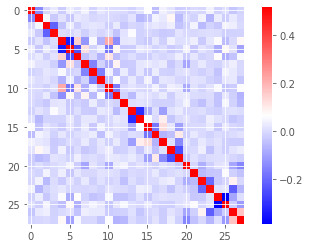

Average Non-Ictal


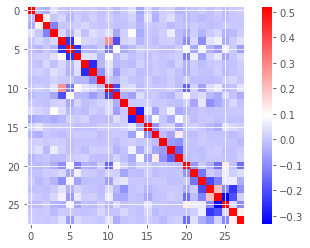

Average Ictal and Non-Ictal Simularity Matrix for GDE
Average ictal


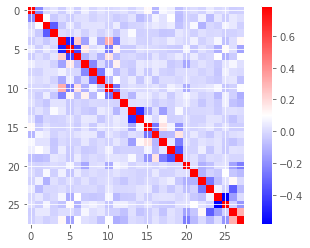

Average Non-Ictal


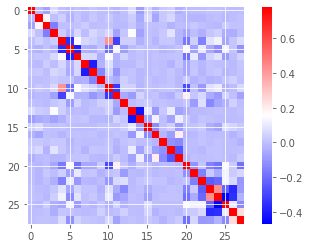

Sample Ictal and Non-Ictal Simularity Matrix for GCN
sample ictal


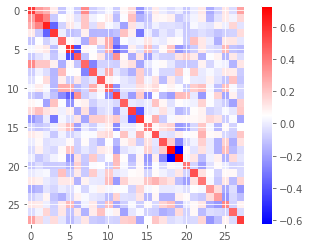

sample Non-Ictal


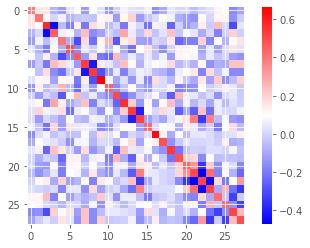

Sample Ictal and Non-Ictal Simularity Matrix for GDE
sample ictal


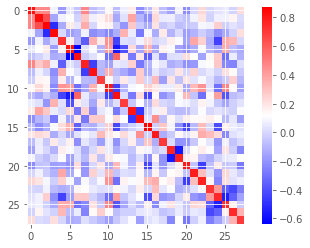

sample Non-Ictal


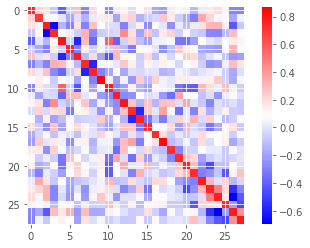

----------Training MLP-----------
0.383 ----------saved-----------


C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


0.385 ----------saved-----------
0.395 ----------saved-----------
0.407 ----------saved-----------
0.42 ----------saved-----------
0.433 ----------saved-----------
0.444 ----------saved-----------
0.458 ----------saved-----------
0.47 ----------saved-----------
0.483 ----------saved-----------
0.491 ----------saved-----------
0.499 ----------saved-----------
0.509 ----------saved-----------
0.519 ----------saved-----------
0.526 ----------saved-----------
0.532 ----------saved-----------
0.538 ----------saved-----------
0.542 ----------saved-----------
0.548 ----------saved-----------
0.552 ----------saved-----------
0.557 ----------saved-----------
0.561 ----------saved-----------
0.57 ----------saved-----------
0.574 ----------saved-----------
0.576 ----------saved-----------
0.579 ----------saved-----------
0.586 ----------saved-----------
0.588 ----------saved-----------
0.595 ----------saved-----------
0.597 ----------saved-----------
0.597 ----------saved-----------
0.6 ---------

In [85]:
IM = Integrated_Model(GCNparameters, GDEparameters, MLPparametersGCN, MLPparametersGDE, dm, create_DAD(Araw))

GCN accuracy:
device set to cuda
threshold: 0.05  validation loss: 0.376 F1 accuracy 0.318 Precision accuracy 0.23 Recall accuracy 0.512 AUC accuracy: 0.67
device set to cuda
threshold: 0.1  validation loss: 0.376 F1 accuracy 0.362 Precision accuracy 0.32 Recall accuracy 0.416 AUC accuracy: 0.67
device set to cuda
threshold: 0.15  validation loss: 0.376 F1 accuracy 0.36 Precision accuracy 0.397 Recall accuracy 0.33 AUC accuracy: 0.67
device set to cuda
threshold: 0.2  validation loss: 0.376 F1 accuracy 0.34 Precision accuracy 0.467 Recall accuracy 0.268 AUC accuracy: 0.67
device set to cuda
threshold: 0.25  validation loss: 0.376 F1 accuracy 0.327 Precision accuracy 0.565 Recall accuracy 0.23 AUC accuracy: 0.67
device set to cuda
threshold: 0.3  validation loss: 0.376 F1 accuracy 0.303 Precision accuracy 0.661 Recall accuracy 0.196 AUC accuracy: 0.67
device set to cuda
threshold: 0.35  validation loss: 0.376 F1 accuracy 0.292 Precision accuracy 0.745 Recall accuracy 0.182 AUC accuracy:

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 0.1  validation loss: 0.3557 F1 accuracy 0.491 Precision accuracy 0.505 Recall accuracy 0.478 AUC accuracy: 0.743
device set to cuda
threshold: 0.15  validation loss: 0.3557 F1 accuracy 0.477 Precision accuracy 0.597 Recall accuracy 0.397 AUC accuracy: 0.743
device set to cuda
threshold: 0.2  validation loss: 0.3557 F1 accuracy 0.466 Precision accuracy 0.664 Recall accuracy 0.359 AUC accuracy: 0.743
device set to cuda
threshold: 0.25  validation loss: 0.3557 F1 accuracy 0.445 Precision accuracy 0.728 Recall accuracy 0.321 AUC accuracy: 0.743
device set to cuda
threshold: 0.3  validation loss: 0.3557 F1 accuracy 0.428 Precision accuracy 0.803 Recall accuracy 0.292 AUC accuracy: 0.743
device set to cuda
threshold: 0.35  validation loss: 0.3557 F1 accuracy 0.388 Precision accuracy 0.828 Recall accuracy 0.254 AUC accuracy: 0.743
device set to cuda
threshold: 0.4  validation loss: 0.3557 F1 accuracy 0.361 Precision accuracy 0.842 Recall accuracy 0.23 AUC accuracy: 0.743
device set to cuda


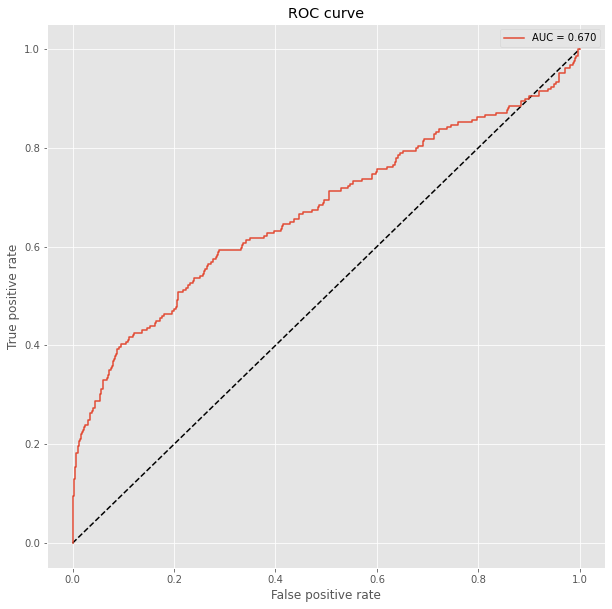

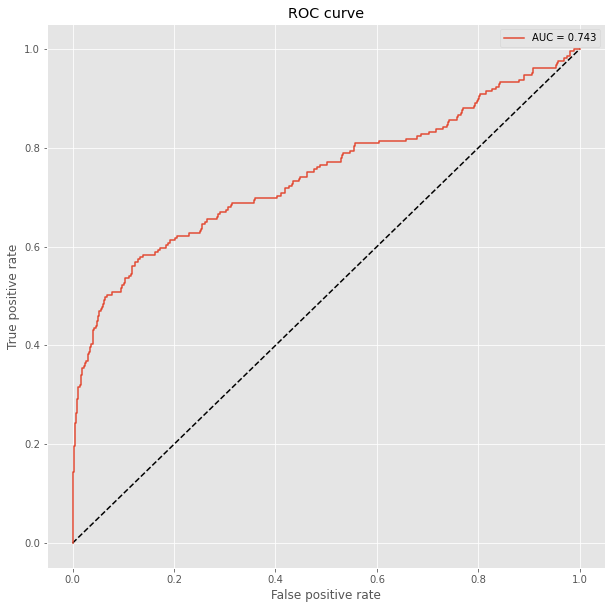

In [86]:
IM.print_accuracy(dm, Araw, device_name = 'cpu')